In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('Downloads/LoanStats3d.csv',
    skipinitialspace=True,
    header=1)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Background info from https://en.wikipedia.org/wiki/LendingClub:

LendingClub = peer-to-peer (P2P) lending company in the US. 
"The company enables borrowers to create unsecured personal loans between $1,000 and $40,000. The standard loan period is three years. 

Investors can search and browse the loan listings on LendingClub website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. 

Investors make money from interest. 

LendingClub makes money by charging borrowers an origination fee and investors a service fee."  - Wikipedia


LendingClub website: https://www.lendingclub.com/investing/institutional/overview

"Banks, financial advisors, and institutions are increasingly looking to invest in marketplace lending seeking higher yields, diversification, and low correlation.1 In partnering with LendingClub, investors can access consumer credit through whole loans, securitizations, or certificates.

With about $50 billion invested across more than 3 million customers, we’re proud to be America’s largest online credit marketplace." - LendingClub

Types of investors:
asset managers, banks, broker-dealers, hedge funds, financial advisors, insurance companies, registered investment advisors, pension funds, foundations, or endowments.

Goal of this project:
Build a classification model that will assist investors in choosing loan listings that will yield high return on their investment.  

Columns 'grade' and 'sub_grade:
How LendingClub assigns Loan grade:
https://www.lendingclub.com/foliofn/rateDetail.action

Sub-grade:  interest rate, borrower's risk and volatility, credit score, and etc. adjusted to loan amount and loan terms.  

[Text(0, 0, 'C1'),
 Text(0, 0, 'C2'),
 Text(0, 0, 'B4'),
 Text(0, 0, 'C3'),
 Text(0, 0, 'C4'),
 Text(0, 0, 'B3'),
 Text(0, 0, 'B5'),
 Text(0, 0, 'A5'),
 Text(0, 0, 'B2'),
 Text(0, 0, 'B1'),
 Text(0, 0, 'C5'),
 Text(0, 0, 'D1'),
 Text(0, 0, 'A4'),
 Text(0, 0, 'D2'),
 Text(0, 0, 'A1'),
 Text(0, 0, 'D3'),
 Text(0, 0, 'A2'),
 Text(0, 0, 'D4'),
 Text(0, 0, 'A3'),
 Text(0, 0, 'D5'),
 Text(0, 0, 'E1'),
 Text(0, 0, 'E2'),
 Text(0, 0, 'E3'),
 Text(0, 0, 'E4'),
 Text(0, 0, 'E5'),
 Text(0, 0, 'F1'),
 Text(0, 0, 'F2'),
 Text(0, 0, 'F3'),
 Text(0, 0, 'F4'),
 Text(0, 0, 'F5'),
 Text(0, 0, 'G1'),
 Text(0, 0, 'G2'),
 Text(0, 0, 'G3'),
 Text(0, 0, 'G4'),
 Text(0, 0, 'G5')]

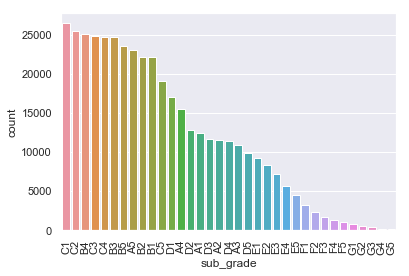

In [3]:
import seaborn as sns
sns.set()
ax= sns.countplot('sub_grade', data=data, order = data['sub_grade'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'C'),
 Text(0, 0, 'B'),
 Text(0, 0, 'A'),
 Text(0, 0, 'D'),
 Text(0, 0, 'E'),
 Text(0, 0, 'F'),
 Text(0, 0, 'G')]

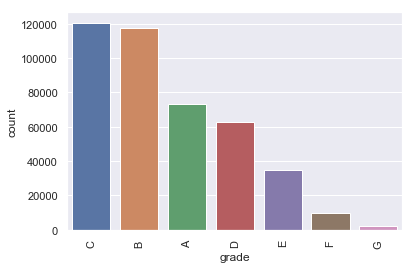

In [4]:
ax= sns.countplot('grade', data=data, order = data['grade'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Data exploring/cleaning: 

Dataset variable info from https://www.rubydoc.info/gems/lending_club/0.0.2/LendingClub%2FLoan:total_il_high_credit_limit  and kaggle

In [5]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [6]:
data.shape

(421097, 111)

In [7]:
list(data.columns)

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_

list of unncessary variables and variables that could cause data leakage in determining loan status:
'id','member_id','issue_d','url','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp'

In [8]:
data=data.drop(['id','member_id','issue_d','url','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt','next_pymnt_d','out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp'], axis=1)

In [9]:
data[['loan_amnt']].describe()

,loan_amnt
count,421095.000000
mean,15240.285862
std,8571.325901
min,1000.000000
25%,8500.000000
50%,14000.000000
75%,20000.000000
max,35000.000000


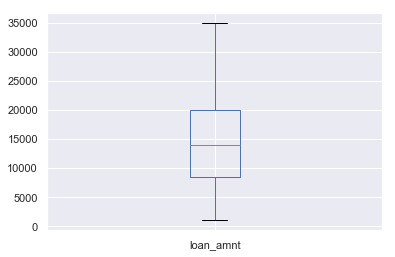

In [10]:
boxplot = data.boxplot(column=['loan_amnt'])
#Expected graph as loans range from 1000 - 40,000 as stated above

In [11]:
print(data['loan_amnt'].isnull().mean()*100)
#very small.  Will drop them.

0.00047494995214879233


In [12]:
data=data.dropna(subset=['loan_amnt'])

emp_title=employment title
emp_length=employement length in months.  Null= not employed.

If they are correlated with loan status (b/w categorical variables), keep.

In [13]:
a=pd.crosstab(index=data['emp_title'], columns=data['loan_status'])

In [14]:
c=pd.crosstab(index=data['emp_length'], columns=data['loan_status'])
c

loan_status,Charged Off,Current,Default,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
emp_length,,,,,,,
1 year,2152,18505,46,5666,297,140,667
10+ years,8632,97640,244,30067,1447,581,2910
2 years,2684,25319,83,7982,401,136,892
3 years,2370,22670,68,7045,351,158,768
4 years,1734,16619,57,5160,271,101,564
5 years,1790,16938,52,5216,253,110,571
6 years,1166,11500,28,3550,183,61,350
7 years,1281,12413,33,3977,203,88,419
8 years,1492,14573,43,4621,219,101,511


[Text(0, 0, '10+ years'),
 Text(0, 0, '8 years'),
 Text(0, 0, '5 years'),
 Text(0, 0, '3 years'),
 Text(0, 0, '6 years'),
 Text(0, 0, '1 year'),
 Text(0, 0, '4 years'),
 Text(0, 0, '7 years'),
 Text(0, 0, '2 years'),
 Text(0, 0, '9 years'),
 Text(0, 0, '< 1 year')]

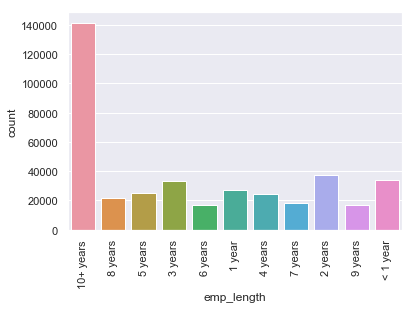

In [15]:
ax=sns.countplot('emp_length', data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [16]:
data['emp_length']=data['emp_length'].str.replace(' years', '')

In [17]:
data['emp_length']=data['emp_length'].str.replace('+', '')

In [18]:
data['zip_code']=data['zip_code'].str.replace('xx', '')

In [19]:
data['revol_util']=data['revol_util'].str.replace('%', '')

In [20]:
data['term']=data['term'].str.replace(' months', '')

In [21]:
data['int_rate']=data['int_rate'].str.replace('%','')

In [22]:
data.dtypes

loan_amnt                         float64
funded_amnt                       float64
funded_amnt_inv                   float64
term                               object
int_rate                           object
installment                       float64
grade                              object
sub_grade                          object
emp_title                          object
emp_length                         object
home_ownership                     object
annual_inc                        float64
verification_status                object
loan_status                        object
pymnt_plan                         object
desc                               object
purpose                            object
title                              object
zip_code                           object
addr_state                         object
dti                               float64
delinq_2yrs                       float64
earliest_cr_line                   object
inq_last_6mths                    

In [23]:
#replace column with small number of missing data with its' median value
for col in data.dtypes[data.dtypes == 'float64'].index:
    data[col].fillna(data[col].median(), inplace=True)

In [24]:
data.isnull().mean()*100

loan_amnt                          0.000000
funded_amnt                        0.000000
funded_amnt_inv                    0.000000
term                               0.000000
int_rate                           0.000000
installment                        0.000000
grade                              0.000000
sub_grade                          0.000000
emp_title                          5.669505
emp_length                         5.655968
home_ownership                     0.000000
annual_inc                         0.000000
verification_status                0.000000
loan_status                        0.000000
pymnt_plan                         0.000000
desc                              99.989314
purpose                            0.000000
title                              0.031347
zip_code                           0.000000
addr_state                         0.000000
dti                                0.000000
delinq_2yrs                        0.000000
earliest_cr_line                

In [25]:
#drop columns with large amount of missing data:
data=data.drop(['mths_since_recent_revol_delinq','mths_since_recent_inq','mths_since_recent_bc_dlq','mths_since_last_record','verification_status_joint','mths_since_last_delinq','desc'], axis=1)

In [26]:
missing_data=pd.DataFrame(data.isnull().mean()*100)
missing_data.iloc[:,:]

,0
loan_amnt,0.000000
funded_amnt,0.000000
funded_amnt_inv,0.000000
term,0.000000
int_rate,0.000000
installment,0.000000
grade,0.000000
sub_grade,0.000000
emp_title,5.669505
emp_length,5.655968


In [27]:
#drop rows with small number of missing data:
data=data.dropna(subset=['emp_title','emp_length','title','revol_util','last_credit_pull_d'])

In [28]:
data.shape

(396727, 88)

In [29]:
data=pd.get_dummies(data=data, columns=['initial_list_status','title','home_ownership','verification_status','grade','sub_grade','application_type','purpose','addr_state'])

In [30]:
data.iloc[:5,113:]

,verification_status_Source Verified,verification_status_Verified,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data['emp_length'].unique()

array(['10', '8', '5', '3', '6', '1 year', '4', '7', '2', '9', '< 1 year'],
      dtype=object)

In [32]:
data=data.drop(['emp_title','pymnt_plan','policy_code'], axis=1)

In [33]:
data.loc[data['emp_length']== '< 1 year']

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
27,17600.0,17600.0,17600.0,36,5.32,530.03,< 1 year,88000.0,Fully Paid,672,...,0,0,0,0,0,0,0,0,0,0
30,16000.0,16000.0,16000.0,60,17.97,406.04,< 1 year,109000.0,Fully Paid,880,...,0,0,0,0,0,0,0,0,0,0
34,21000.0,21000.0,21000.0,60,13.99,488.53,< 1 year,52000.0,Current,441,...,0,0,0,0,0,0,0,0,0,0
41,8650.0,8650.0,8650.0,36,5.32,260.50,< 1 year,100000.0,Current,462,...,0,0,0,0,0,0,0,0,0,0
61,21875.0,21875.0,21875.0,36,11.99,726.46,< 1 year,47590.0,Current,347,...,0,0,0,0,0,0,0,0,0,0
84,8000.0,8000.0,8000.0,36,10.78,261.08,< 1 year,45000.0,Current,482,...,0,0,0,0,0,0,0,0,0,0
93,10000.0,10000.0,10000.0,60,16.59,246.33,< 1 year,30000.0,Fully Paid,447,...,0,0,0,0,0,0,0,0,0,0
100,3600.0,3600.0,3600.0,36,11.48,118.68,< 1 year,85000.0,Current,220,...,0,0,0,0,1,0,0,0,0,0
124,10000.0,10000.0,10000.0,36,12.88,336.37,< 1 year,60000.0,Fully Paid,986,...,0,0,0,0,0,0,1,0,0,0
143,20000.0,20000.0,20000.0,36,10.78,652.70,< 1 year,55000.0,Current,355,...,0,0,0,0,0,0,0,0,0,0


In [34]:
data.loc[data['emp_length']== '1 year']

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,...,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY
12,16000.0,16000.0,16000.0,60,12.88,363.07,1 year,70000.0,Current,786,...,0,0,1,0,0,0,0,0,0,0
31,12000.0,12000.0,12000.0,36,10.78,391.62,1 year,98000.0,Current,993,...,0,0,0,0,0,0,1,0,0,0
64,16000.0,16000.0,16000.0,60,13.44,367.67,1 year,42000.0,Current,019,...,0,0,0,0,0,0,0,0,0,0
70,25000.0,25000.0,25000.0,36,5.32,752.87,1 year,150000.0,Current,054,...,0,0,0,0,0,1,0,0,0,0
87,15000.0,15000.0,15000.0,36,10.78,489.52,1 year,40000.0,Current,787,...,0,0,1,0,0,0,0,0,0,0
91,9000.0,9000.0,9000.0,36,9.17,286.92,1 year,50000.0,Current,670,...,0,0,0,0,0,0,0,0,0,0
123,8000.0,8000.0,8000.0,36,5.32,240.92,1 year,50000.0,Fully Paid,481,...,0,0,0,0,0,0,0,0,0,0
149,16000.0,16000.0,16000.0,36,15.77,560.70,1 year,70000.0,Current,088,...,0,0,0,0,0,0,0,0,0,0
160,12600.0,12600.0,12600.0,60,14.85,298.77,1 year,175000.0,Fully Paid,206,...,0,0,0,0,0,0,0,0,0,0
165,35000.0,35000.0,35000.0,36,9.17,1115.77,1 year,105000.0,Fully Paid,322,...,0,0,0,0,0,0,0,0,0,0


In [35]:
data['emp_length']=data['emp_length'].replace({'1 year': 1, '< 1 year': 0})

In [36]:
data['int_rate'].dtype

dtype('O')

In [37]:
data['int_rate']=pd.to_numeric(data['int_rate'], errors='coerce')

In [38]:
data=data.rename(index={'int_rate': "interest rate in %", 'term': "term in months"})

In [39]:
data['earliest_cr_line_year'] = pd.DatetimeIndex(data['earliest_cr_line']).year

In [40]:
data['last_credit_pulled_year']=pd.DatetimeIndex(data['last_credit_pull_d']).year

In [41]:
data=data.drop(['earliest_cr_line','last_credit_pull_d','title_DebtC'], axis=1)

In [42]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,earliest_cr_line_year,last_credit_pulled_year
0,16000.0,16000.0,16000.0,60,14.85,379.39,10,48000.0,Current,297,...,0,0,0,0,0,0,0,0,1991,2017
1,9600.0,9600.0,9600.0,36,7.49,298.58,8,60000.0,Current,299,...,0,0,0,0,0,0,0,0,1996,2017
2,25000.0,25000.0,25000.0,36,7.49,777.55,10,109000.0,Fully Paid,226,...,0,0,1,0,0,0,0,0,2001,2017
3,28000.0,28000.0,28000.0,36,6.49,858.05,10,92000.0,Current,275,...,0,0,0,0,0,0,0,0,1984,2017
4,8650.0,8650.0,8650.0,36,19.89,320.99,8,55000.0,Fully Paid,462,...,0,0,0,0,0,0,0,0,2005,2016


loan status total:
charged off:29178 (collection agencies step in)
current: 287414 (one or more payments have been completed and no payments are past due)
default: 796
full paid: 87989 (loan has been repaid in full, including all principal + interest) 
In grace period: 4320 (loan payment due period.  If paid during this period, marked as"Paid on time" and no late interest is charged). 
late(16-30 days): 1888 (over due for more than 3 days but < 31 days)
late (31-120 days): 9510 (over due for > 31 but < 120 days) 

“Most lenders report as soon as you’re 30 days late...” (https://www.bankrate.com/finance/debt/debt-delinquency-timeline-what-to-expect-1.aspx)


As an investor, would like to avoid the risk of funding borrowers that will end up with loan status of 'late (31-120 days), 'default' and 'charged off'.  

Based on borrower's given info, would like to predict if he/she is more similar to 'full paid' loan status group vs. 'charged off/default/late (31-120 days)' loan status group:  less risky group vs higher risky group to invest in.

In [43]:
data['loan_status']=data['loan_status'].replace({'Fully Paid': 'low risk', 'Charged Off': 'high risk', 'Late (31-120 days)': 'high risk', 'Default':'high risk'})

will drop loan_status column with values current, in grace period, and late (16-30 days) as they can't be labeled as either high or low risk for the purpose of this project

In [44]:
data.shape

(396727, 218)

In [45]:
data.drop(data.loc[data['loan_status']=='Current'].index, inplace=True)

In [46]:
data.drop(data.loc[data['loan_status']=='In Grace Period'].index, inplace=True)

In [47]:
data.drop(data.loc[data['loan_status']=='Late (16-30 days)'].index, inplace=True)

In [48]:
data.shape

(120537, 218)

In [49]:
len(data.loc[data['loan_status']=='high risk'])

36661

In [50]:
len(data.loc[data['loan_status']=='low risk'])

83876

In [51]:
data1=pd.DataFrame(data.loc[data['loan_status']=='high risk'])
data2=pd.DataFrame(data.loc[data['loan_status']=='low risk'])

we have more low risk samples than high risk (about twice as much).
do random sample selection for low risk (half the original size) to prevent class imbalance.

In [52]:
data3=pd.DataFrame(data2.sample(frac=0.45, random_state=10))

In [53]:
frames = [data1, data3]

final_data_table = pd.concat(frames)
final_data_table.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,zip_code,...,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,earliest_cr_line_year,last_credit_pulled_year
76,23975.0,23975.0,23975.0,60,19.89,633.73,10,70000.0,high risk,220,...,0,0,1,0,0,0,0,0,1995,2017
83,27300.0,27300.0,27300.0,36,17.27,977.00,10,65000.0,high risk,117,...,0,0,0,0,0,0,0,0,2002,2017
94,23100.0,23100.0,23100.0,60,20.50,618.46,2,110000.0,high risk,197,...,0,0,0,0,0,0,0,0,1986,2016
126,14400.0,14400.0,14400.0,60,19.48,377.36,3,73320.0,high risk,136,...,0,0,0,0,0,0,0,0,2006,2017
140,25825.0,25825.0,25825.0,60,26.06,774.14,6,68000.0,high risk,207,...,0,0,0,0,0,0,0,0,2002,2017


In [54]:
df_dummies = pd.get_dummies(final_data_table['loan_status'])
del df_dummies[df_dummies.columns[-1]]
df_new = pd.concat([final_data_table, df_dummies], axis=1)
del df_new['loan_status']
#high risk: 1
#low risk: 0

In [55]:
#drop columns with value = 0:
df_new=df_new.drop(['home_ownership_ANY','title_odymeds','title_New Baby and New House (CC Consolidate)',
       'title_Pay off Lowes Card',
       'title_Paying off higher interest cards & auto', 'title_SAVE',
       'title_Simple Loan Until Contract Is Completed', 'title_Student Loan',
       'title_considerate', 'title_new day'], axis=1)

In [56]:
df_new=df_new.apply(pd.to_numeric)

In [57]:
x = pd.DataFrame(df_new.values)
x.shape

(74405, 208)

In [58]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,23975.0,23975.0,23975.0,60.0,19.89,633.73,10.0,70000.0,220.0,33.20,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1995.0,2017.0,1.0
1,27300.0,27300.0,27300.0,36.0,17.27,977.00,10.0,65000.0,117.0,25.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002.0,2017.0,1.0
2,23100.0,23100.0,23100.0,60.0,20.50,618.46,2.0,110000.0,197.0,20.43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1986.0,2016.0,1.0
3,14400.0,14400.0,14400.0,60.0,19.48,377.36,3.0,73320.0,136.0,17.02,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2006.0,2017.0,1.0
4,25825.0,25825.0,25825.0,60.0,26.06,774.14,6.0,68000.0,207.0,31.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2002.0,2017.0,1.0


In [59]:
correlation_matrix = pd.DataFrame(np.corrcoef(x.T))
correlation_matrix.iloc[:,-1]
#correlation of loan_status to explanatory variables

0      0.066109
1      0.066109
2      0.065977
3      0.176599
4      0.319085
5      0.055460
6     -0.042103
7     -0.056779
8     -0.036080
9      0.178596
10     0.028452
11     0.078755
12     0.032995
13     0.016790
14    -0.019214
15     0.121016
16    -0.038375
17     0.025619
18    -0.004999
19     0.000002
20    -0.000150
21     0.007390
22    -0.002868
23    -0.116865
24     0.015679
25     0.007917
26     0.012863
27     0.013563
28    -0.011409
29     0.005129
         ...   
178    0.002356
179    0.009338
180   -0.008163
181    0.004366
182   -0.001407
183    0.004150
184   -0.018564
185    0.010476
186    0.002177
187    0.009185
188    0.034597
189    0.011029
190    0.013216
191   -0.023981
192    0.002768
193   -0.000361
194   -0.010435
195    0.010169
196    0.003677
197    0.002170
198   -0.017991
199    0.001606
200   -0.012298
201   -0.024441
202   -0.008128
203   -0.002718
204   -0.003300
205    0.062549
206    0.310482
207    1.000000
Name: 207, Length: 208, 

explanatory variables with highest correlation with loan_status:

'int_rate'=0.319085
'grade_A'=-0.217273
'last_credit_pulled_year'= 0.31048

In [60]:
df_new.columns[[95,97,98,99,101,102,103,104,105,106,107,108,109,110,111,0,1,2,3,9,11,128,129,39,41,64,71,130,131,121]]

Index(['verification_status_Not Verified', 'verification_status_Verified',
       'grade_A', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'dti', 'inq_last_6mths',
       'sub_grade_E4', 'sub_grade_E5', 'acc_open_past_24mths',
       'bc_open_to_buy', 'num_tl_op_past_12m', 'total_bc_limit',
       'sub_grade_F1', 'sub_grade_F2', 'sub_grade_D2'],
      dtype='object')

In [61]:
df_new.columns[[3,4,41,42,71,100,105,106,107,108,109]]

Index(['term', 'int_rate', 'bc_open_to_buy', 'bc_util', 'total_bc_limit',
       'grade_C', 'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3',
       'sub_grade_A4', 'sub_grade_A5'],
      dtype='object')

variables with highest correlation with 'int_rate:
'verification_status_Not Verified', 'verification_status_Verified',
       'grade_A', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'sub_grade_A1', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4',
       'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'loan_amnt',
       'funded_amnt', 'funded_amnt_inv', 'term', 'dti', 'inq_last_6mths',
       'high risk', 'sub_grade_E4', 'sub_grade_E5', 'acc_open_past_24mths',
       'bc_open_to_buy', 'num_tl_op_past_12m', 'total_bc_limit',
       'sub_grade_F1', 'sub_grade_F2', 'sub_grade_D2'
       
variables with highest correlation with 'grade_A':
'term', 'int_rate', 'high risk', 'bc_open_to_buy', 'bc_util',
       'total_bc_limit', 'grade_C', 'sub_grade_A1', 'sub_grade_A2',
       'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5'
       
No other variable with significant correlation with 'last_credit_pulled_year'.

In [62]:
x2=final_data_table[['int_rate','grade_A','last_credit_pulled_year']].values
y2=df_new['high risk'].values

In [63]:
from sklearn.model_selection import train_test_split
x2_train, x2_test, y2_train, y2_test = train_test_split(x2,y2, test_size=0.2, random_state=1)

Model one: KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier

In [65]:
model = KNeighborsClassifier()

In [66]:
model.fit(x2_train, y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [67]:
y_pred=model.predict(x2_test)

In [68]:
from sklearn.metrics import roc_curve, auc

In [69]:
false_positive_rate, true_positive_rate, thresholds=roc_curve(y2_test,y_pred)

In [70]:
roc_auc=auc(false_positive_rate, true_positive_rate)

In [71]:
roc_auc

0.6306060614928529

KNN classifier AUC score using parameter default: 0.86 
AUC != accuracy.  AUC measures how 'true positive rate' and 'false positive rate' trade off.
AUC near to the 0= poor.  It's reciprocating the result. 
AUC score 0.5= has no class separation capacity whatsoever. 
AUC score 1= good classifier.
KNN tuning:

In [72]:
neighbors=list(range(1,50))

In [73]:
train_results=[]
test_results=[]

In [74]:
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(x2_train, y2_train)
    train_pred=model.predict(x2_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y2_train, train_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    
    y_pred2=model.predict(x2_test)
    false_positive_rate2, true_positive_rate2, thresholds = roc_curve(y2_test, y_pred2)
    roc_auc2=auc(false_positive_rate2, true_positive_rate2)
    test_results.append(roc_auc2)

In [75]:
from matplotlib.legend_handler import HandlerLine2D

Text(0.5, 0, 'n_neighbors')

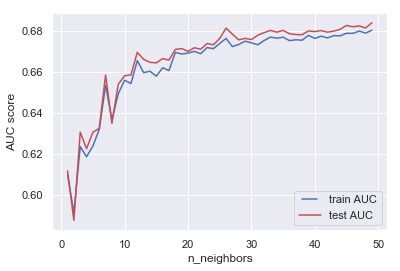

In [76]:
line1, = plt.plot(neighbors, train_results, 'b', label='train AUC')
line2, = plt.plot(neighbors, test_results, 'r', label='test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')

increasing the n_neighbors improves the AUC score.
Check if the model is overfitting by doing cross_val_score.

In [77]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(model, x2_train, y2_train, cv=20))

[0.66644273 0.66879409 0.67215317 0.69230769 0.67215317 0.66845818
 0.67248908 0.68245968 0.68783602 0.69556452 0.67842742 0.68111559
 0.69354839 0.68245968 0.69590054 0.66129032 0.69018817 0.67663866
 0.69579832 0.6994958 ]


cross_val_score: pretty consistent.  no overfitting

In [78]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [79]:
tuning_1={'n_neighbors':[10,20,30, 40, 50]}

In [80]:
tuning1=GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [81]:
tuning1.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_neighbors': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [82]:
GridSearchCV.score(tuning1, x2_train, y2_train), tuning1.best_params_, tuning1.best_score_

(0.6806834218130502, {'n_neighbors': 50}, 0.6750726456706566)

In [83]:
new_KNN=KNeighborsClassifier(n_neighbors=50)

In [84]:
new_KNN.fit(x2_train, y2_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='uniform')

In [85]:
print('Accuracy of the new_KNN on test set: {:,.3f}'.format(new_KNN.score(x2_test, y2_test)))

Accuracy of the new_KNN on test set: 0.683


In [86]:
y_predicted=new_KNN.predict(x2_test)

In [87]:
print(classification_report(y2_test, y_predicted))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      7497
           1       0.69      0.66      0.67      7384

   micro avg       0.68      0.68      0.68     14881
   macro avg       0.68      0.68      0.68     14881
weighted avg       0.68      0.68      0.68     14881



In [215]:
print(cross_val_score(new_KNN, x2_test, y2_test, cv=5))

[0.6771918  0.68592543 0.67641129 0.68850806 0.67563025]


Model two: Random Forest Classifier

In [88]:
#RFC using default parameters

In [89]:
from sklearn import ensemble
rfc=ensemble.RandomForestClassifier()

In [90]:
rfc.fit(x2_train, y2_train)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
print('Accuracy of the rfc on test set: {:.3f}'.format(rfc.score(x2_test, y2_test)))
predicted=rfc.predict(x2_test)
print(classification_report(y2_test, predicted))

Accuracy of the rfc on test set: 0.688
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      7497
           1       0.68      0.70      0.69      7384

   micro avg       0.69      0.69      0.69     14881
   macro avg       0.69      0.69      0.69     14881
weighted avg       0.69      0.69      0.69     14881



In [92]:
print(cross_val_score(rfc, x2_train, y2_train, cv=20))

[0.66509909 0.66913    0.67618408 0.69936177 0.68155862 0.6731609
 0.67349681 0.68077957 0.67909946 0.68985215 0.68413978 0.68548387
 0.69657258 0.68817204 0.69522849 0.66364247 0.68548387 0.68033613
 0.69411765 0.68705882]


In [93]:
print(cross_val_score(rfc, x2_test, y2_test, cv=20))

[0.67114094 0.67919463 0.68187919 0.68322148 0.67069892 0.71908602
 0.64919355 0.68010753 0.65860215 0.68817204 0.68010753 0.69892473
 0.67741935 0.70026882 0.71774194 0.68548387 0.71236559 0.69717362
 0.66083445 0.66218035]


In [94]:
tuning_1={'n_estimators':[10,20,30],'max_depth':[2,3,4,5,6,7]}

In [95]:
tuning_2={'min_samples_split':[2,4,6,8,10,20,40,60,100]}

In [96]:
tuning_3={'min_samples_leaf':[1,3,5,7,9]}

In [97]:
tuning_4={'max_features':[1,2]}

In [98]:
tuning1=GridSearchCV(estimator=ensemble.RandomForestClassifier(criterion='gini', 
                    min_samples_split=2, min_samples_leaf=1, max_features=2, random_state=10), 
                   param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [99]:
tuning1.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [10, 20, 30], 'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [100]:
GridSearchCV.score(tuning1, x2_train, y2_train), tuning1.best_params_, tuning1.best_score_

(0.6849506081580539, {'max_depth': 6, 'n_estimators': 30}, 0.68338863887188)

In [101]:
tuning2=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=6,criterion='gini', 
                    min_samples_leaf=1, max_features=2, random_state=10), 
                   param_grid=tuning_2, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [102]:
tuning2.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': [2, 4, 6, 8, 10, 20, 40, 60, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [103]:
GridSearchCV.score(tuning2, x2_train, y2_train), tuning2.best_params_, tuning2.best_score_

(0.6849506081580539, {'min_samples_split': 2}, 0.68338863887188)

In [104]:
tuning3=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=7,criterion='gini', 
                    min_samples_split=2, max_features=2, random_state=10), 
                   param_grid=tuning_3, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [105]:
tuning3.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_leaf': [1, 3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [106]:
GridSearchCV.score(tuning3, x2_train, y2_train), tuning3.best_params_, tuning3.best_score_

(0.6851018076742155, {'min_samples_leaf': 9}, 0.6834725567573231)

In [107]:
tuning4=GridSearchCV(estimator=ensemble.RandomForestClassifier(n_estimators=30, max_depth=7,criterion='gini', 
                    min_samples_split=20, min_samples_leaf=9, random_state=10), 
                   param_grid=tuning_4, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [108]:
tuning4.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [109]:
GridSearchCV.score(tuning4, x2_train, y2_train), tuning4.best_params_, tuning4.best_score_

(0.684967408104294, {'max_features': 2}, 0.6833717672394329)

In [110]:
new_rfc=ensemble.RandomForestClassifier(n_estimators=30, criterion='gini', max_depth=7, min_samples_split=20, min_samples_leaf=9,
                                       max_features=2, random_state=10)

In [111]:
new_rfc.fit(x2_train, y2_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=2, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=9, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=None,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

In [112]:
print('Accuracy of the new_rfc on test set: {:,.3f}'.format(new_rfc.score(x2_test, y2_test)))

Accuracy of the new_rfc on test set: 0.687


In [113]:
y_predicted=new_rfc.predict(x2_test)

In [114]:
print(classification_report(y2_test, y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.66      0.68      7497
           1       0.67      0.72      0.69      7384

   micro avg       0.69      0.69      0.69     14881
   macro avg       0.69      0.69      0.69     14881
weighted avg       0.69      0.69      0.69     14881



In [115]:
print(cross_val_score(new_rfc, x2_test, y2_test, cv=10))

[0.68368032 0.69576897 0.6937542  0.66890531 0.67741935 0.69623656
 0.69287634 0.70813719 0.69872226 0.66577001]


Model three: GBM

In [116]:
from sklearn.ensemble import GradientBoostingClassifier

In [117]:
gbm=GradientBoostingClassifier()

In [118]:
gbm.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [119]:
features=list(x2)

Text(0, 0.5, 'Feature Importance Score')

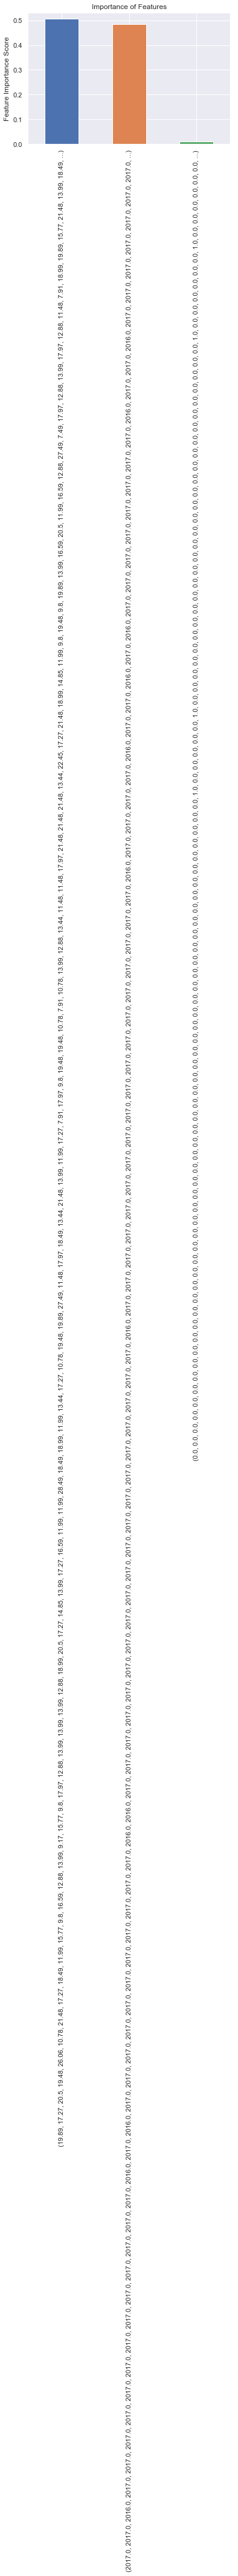

In [120]:
feature_importance=pd.Series(gbm.feature_importances_, features).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

feature importance rank: int_rate > last_credit_pulled_year > grade_A

In [121]:
print('Accuracy of the GBM on test set: {:.3f}'.format(gbm.score(x2_test, y2_test)))
y_pred= gbm.predict(x2_test)
print(classification_report(y2_test, y_pred))

Accuracy of the GBM on test set: 0.688
              precision    recall  f1-score   support

           0       0.70      0.66      0.68      7497
           1       0.67      0.72      0.70      7384

   micro avg       0.69      0.69      0.69     14881
   macro avg       0.69      0.69      0.69     14881
weighted avg       0.69      0.69      0.69     14881



In [122]:
gbm_tuning1={'n_estimators':[100,250,500,750,1000], 'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001]}

In [123]:
gbm_tuning=GridSearchCV(estimator=GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                                            subsample=1, max_features='sqrt', random_state=10),
                       param_grid=gbm_tuning1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [124]:
gbm_tuning.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sam...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': [100, 250, 500, 750, 1000], 'learning_rate': [0.15, 0.1, 0.05, 0.01, 0.005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [125]:
GridSearchCV.score(gbm_tuning, x2_train, y2_train), gbm_tuning.best_params_, gbm_tuning.best_score_

(0.6854714064914992,
 {'learning_rate': 0.05, 'n_estimators': 500},
 0.6835229458716939)

In [126]:
new_gbm=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=500,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [127]:
new_gbm.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [128]:
gbm_tuning_y_predicted=new_gbm.predict(x2_test)

In [129]:
print(classification_report(y2_test, gbm_tuning_y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      7497
           1       0.68      0.71      0.69      7384

   micro avg       0.69      0.69      0.69     14881
   macro avg       0.69      0.69      0.69     14881
weighted avg       0.69      0.69      0.69     14881



In [130]:
print('Accuracy of the new gbm model after tuning on test set: {:,.3f}'.format(gbm_tuning.score(x2_test, y2_test)))

Accuracy of the new gbm model after tuning on test set: 0.688


In [131]:
gbm_tuning2={'max_depth':[2,3,4,5,6,7]}

In [132]:
gbm_second_tuning=GridSearchCV(estimator=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=500,
              learning_rate=0.05, loss='deviance',
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
                       param_grid=gbm_tuning2, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [133]:
gbm_second_tuning.fit(x2_train, y2_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sa...        subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [134]:
GridSearchCV.score(gbm_second_tuning, x2_train, y2_train), gbm_second_tuning.best_params_, gbm_second_tuning.best_score_

(0.685454606545259, {'max_depth': 4}, 0.6834389320284883)

In [151]:
new_gbm2=GradientBoostingClassifier(criterion='friedman_mse', n_estimators=500,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [152]:
new_gbm2.fit(x2_train, y2_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=4,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [153]:
gbm_tuning_y_predicted2=new_gbm2.predict(x2_test)

In [154]:
print(classification_report(y2_test, gbm_tuning_y_predicted2))

              precision    recall  f1-score   support

           0       0.70      0.67      0.68      7497
           1       0.68      0.71      0.69      7384

   micro avg       0.69      0.69      0.69     14881
   macro avg       0.69      0.69      0.69     14881
weighted avg       0.69      0.69      0.69     14881



In [155]:
#using all the features:

In [156]:
x3=final_data_table.drop('loan_status', axis=1).values
y3=df_new['high risk'].values

In [157]:
x3_train, x3_test, y3_train, y3_test = train_test_split(x3,y3, test_size=0.2, random_state=1)

In [158]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

In [159]:
scaler.fit(x3_train)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [160]:
x3_train=scaler.transform(x3_train)
x3_test=scaler.transform(x3_test)

/Users/laurakim/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/laurakim/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [161]:
from sklearn.decomposition import PCA
pca=PCA(0.95)
pca.fit(x3_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [162]:
x3_train=pca.transform(x3_train)
x3_test=pca.transform(x3_test)

In [163]:
#KNN:
model = KNeighborsClassifier()

In [164]:
model.fit(x3_train, y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [166]:
print(cross_val_score(model, x3_train, y3_train, cv=10))

[0.59667395 0.60725685 0.60641693 0.60910465 0.6096086  0.61145641
 0.6106165  0.616367   0.61199798 0.61586288]


In [167]:
y_predicted=model.predict(x3_test)

In [168]:
print(classification_report(y3_test, y_predicted))

              precision    recall  f1-score   support

           0       0.62      0.60      0.61      7497
           1       0.61      0.63      0.62      7384

   micro avg       0.62      0.62      0.62     14881
   macro avg       0.62      0.62      0.62     14881
weighted avg       0.62      0.62      0.62     14881



In [169]:
tuning_1={'n_neighbors':[20,30, 40, 50]}

In [170]:
knn_tuning1=GridSearchCV(estimator=KNeighborsClassifier(), 
                     param_grid=tuning_1, scoring='accuracy',n_jobs=4, iid=False, cv=5)

In [173]:
#knn_tuning1.fit(x3_train, y3_train)

In [174]:
#GridSearchCV.score(knn_tuning1, x3_train, y3_train), knn_tuning1.best_params_, knn_tuning1.best_score_

In [175]:
new_knn=KNeighborsClassifier(n_neighbors=50)

In [176]:
new_knn.fit(x3_train, y3_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=50, p=2,
           weights='uniform')

In [177]:
print('Accuracy of the new_knn on test set: {:,.3f}'.format(new_knn.score(x3_test, y3_test)))

Accuracy of the new_knn on test set: 0.652


In [189]:
new_knn_y_predicted=new_knn.predict(x3_test)

In [190]:
print(classification_report(y3_test, new_knn_y_predicted))

              precision    recall  f1-score   support

           0       0.66      0.65      0.65      7497
           1       0.65      0.66      0.65      7384

   micro avg       0.65      0.65      0.65     14881
   macro avg       0.65      0.65      0.65     14881
weighted avg       0.65      0.65      0.65     14881



In [181]:
gbm.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [182]:
print('Accuracy of the gbm on test set: {:,.3f}'.format(gbm.score(x3_test, y3_test)))

Accuracy of the gbm on test set: 0.692


In [183]:
gbm2=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [184]:
gbm2.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [185]:
print('Accuracy of the gbm2 on test set: {:,.3f}'.format(gbm2.score(x3_test, y3_test)))

Accuracy of the gbm2 on test set: 0.698


In [186]:
gbm3=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [187]:
gbm3.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [188]:
print('Accuracy of the gbm3 on test set: {:,.3f}'.format(gbm3.score(x3_test, y3_test)))

Accuracy of the gbm3 on test set: 0.699


In [192]:
new_gbm_y_predicted=gbm2.predict(x3_test)

In [193]:
print(classification_report(y3_test, new_gbm_y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      7497
           1       0.69      0.70      0.70      7384

   micro avg       0.70      0.70      0.70     14881
   macro avg       0.70      0.70      0.70     14881
weighted avg       0.70      0.70      0.70     14881



In [194]:
gbm3_y_predicted=gbm3.predict(x3_test)

In [195]:
print(classification_report(y3_test, gbm3_y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      7497
           1       0.69      0.70      0.70      7384

   micro avg       0.70      0.70      0.70     14881
   macro avg       0.70      0.70      0.70     14881
weighted avg       0.70      0.70      0.70     14881



In [207]:
#gbm3: n_estimator=250, learning_rate=0.1

In [212]:
print(cross_val_score(gbm3, x3_train, y3_train, cv=5))

[0.69578364 0.69737947 0.70295699 0.70497312 0.7015289 ]


In [213]:
print(cross_val_score(gbm3, x3_test, y3_test, cv=5))

[0.68424589 0.69129997 0.68413978 0.69590054 0.68638655]


In [198]:
gbm_tuning4=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [199]:
gbm_tuning4.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.15, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [200]:
gbm_tuning5=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [201]:
gbm_tuning5.fit(x3_train, y3_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=250,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [202]:
gbm_tuning4_y_predicted=gbm_tuning4.predict(x3_test)

In [203]:
print(classification_report(y3_test, gbm_tuning4_y_predicted))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      7497
           1       0.69      0.71      0.70      7384

   micro avg       0.70      0.70      0.70     14881
   macro avg       0.70      0.70      0.70     14881
weighted avg       0.70      0.70      0.70     14881



In [216]:
print(cross_val_score(gbm_tuning4, x3_test, y3_test, cv=5))

[0.67819953 0.69398724 0.68514785 0.69388441 0.69109244]


In [204]:
gbm_tuning5_y_predicted=gbm_tuning5.predict(x3_test)

In [205]:
print(classification_report(y3_test, gbm_tuning5_y_predicted))

              precision    recall  f1-score   support

           0       0.70      0.69      0.70      7497
           1       0.69      0.70      0.70      7384

   micro avg       0.70      0.70      0.70     14881
   macro avg       0.70      0.70      0.70     14881
weighted avg       0.70      0.70      0.70     14881

